# This notebook

## LOOK INTO. 
- Using more or less data.
    - Adding categorical data
    - Only normalize numerical data. One-hot encode other data.
- K-fold validation.
- Different activation functions, and loss functions (mse, msle)
- New features: combine some data for better training:
    - longiture/lattitude combined to distance from centre?
    - Combine stories/floor for a "penthouse" trait.
- Alternative for filling in nan: mean doesnt work if 90% is nan, and the rest is 1 (balcony)
    - One idea: use a model to predict the value based on other data!
    - Simple idea: drop the features with too much nan (>30%)
    - Titanic method: use other correlated cols.
- Normalizing: 
    - Use same scale for all feature data!
    - Want the mean ~0 for the data!

# Import

In [53]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# Specific tf libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Helper functions

In [4]:
fractionOfData = 1

In [5]:
%run ../common_utils.py

# Load data

## Metadata

In [4]:
metaData_apartment = pd.read_json('../data/apartments_meta.json')
metaData_building = pd.read_json('../data/buildings_meta.json')

In [5]:
metaData_apartment.at[0, 'name'] = 'apartment_id'
metaData_building.at[0, 'name'] = 'building_id'

In [6]:
metaData = pd.concat([metaData_apartment, metaData_building])

## Train data

In [13]:
train_apartment = pd.read_csv('../data/apartments_train.csv')

In [14]:
train_building = pd.read_csv('../data/buildings_train.csv')

In [29]:
train = pd.merge(train_apartment, train_building, left_on='building_id', right_on='id')
#train.rename(columns={'id_x' : 'apartment_id', 'id_y' : 'building_id'}, inplace=True)
train.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
train.drop('id_y', axis=1, inplace=True)
# Remove duplicate column after merge.

In [30]:
# Reduce amount of data for performance reasons during implementation.
train = train.head(int(train.shape[0] * 1))
train.head()

,apartment_id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,12,3.0,4045140.0,19.8,5.2,9.6,17.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
2,55,3.0,9500240.0,79.7,17.0,41.5,9.0,3.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,104,3.0,4326660.0,23.4,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
4,106,3.0,4333980.0,23.8,6.1,11.3,9.0,1.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN


In [31]:
print(len(train_apartment))
print(len(train))

23285
23285


## Test data

In [19]:
test_apartment = pd.read_csv('../data/apartments_test.csv')

In [20]:
test_building = pd.read_csv('../data/buildings_test.csv')

In [22]:
test = pd.merge(test_apartment, test_building, left_on='building_id', right_on='id')
test.rename(columns={'id_x' : 'apartment_id'}, inplace=True)
test.drop('id_y', axis=1, inplace=True)
test.tail()

,apartment_id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
9932,33150,NaN,29.0,NaN,NaN,5.0,1.0,NaN,2.64,0.0,...,6,2014.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
9933,33153,NaN,87.0,12.0,NaN,6.0,3.0,NaN,2.50,0.0,...,105к2,NaN,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9934,33163,NaN,58.1,12.0,30.0,14.0,2.0,1.0,2.70,0.0,...,12,2016.0,NaN,17.0,0.0,1.0,1.0,NaN,NaN,NaN
9935,33208,1.0,54.7,5.5,36.9,2.0,3.0,NaN,2.64,1.0,...,10К2,1963.0,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0
9936,33221,1.0,71.5,7.0,49.0,2.0,3.0,NaN,NaN,NaN,...,2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


## 1 - Expanding on the numerical data
Using longitude and lattitude better.

In [103]:
# "All" numerical features
numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]
outliers_value = 7

# Outlayer removal
no_outlayers = train[(np.abs(stats.zscore(train[["area_total", "price"]])) < outliers_value).all(axis=1)] 

# Labels and targets
labels1 = no_outlayers[numerical_features]
labels1 = labels1.fillna(labels1.mean())
targets1= no_outlayers['price'] # Non nan values here.

# Test
test1 = test[numerical_features]
test1 = test1.fillna(test1.mean())

# Normalize
normalized_labels1 = (labels1-labels1.min())/(labels1.max()-labels1.min())
normalized_test1 = (test1-test1.min())/(test1.max()-test1.min())

In [104]:
# Make a copy
labels1_normed_r = normalized_labels1.copy()
test1_normed_r = normalized_test1.copy()

# Move origo to centre
labels1_normed_r['latitude'] = labels1_normed_r['latitude'] -  labels1_normed_r['latitude'].mean()
labels1_normed_r['longitude'] = labels1_normed_r['longitude'] -  labels1_normed_r['longitude'].mean()
test1_normed_r['latitude'] = test1_normed_r['latitude'] -  test1_normed_r['latitude'].mean()
test1_normed_r['longitude'] = test1_normed_r['longitude'] -  test1_normed_r['longitude'].mean()

# Convert to polar coordinates
labels1_normed_r['r'] =  np.sqrt(labels1_normed_r['latitude']**2 + labels1_normed_r['longitude']**2)
labels1_normed_r['theta'] = np.arctan(labels1_normed_r['longitude']/labels1_normed_r['latitude'])
test1_normed_r['r'] =  np.sqrt(test1_normed_r['latitude']**2 + test1_normed_r['longitude']**2)
test1_normed_r['theta'] = np.arctan(test1_normed_r['longitude']/test1_normed_r['latitude'])

<AxesSubplot:xlabel='r', ylabel='theta'>

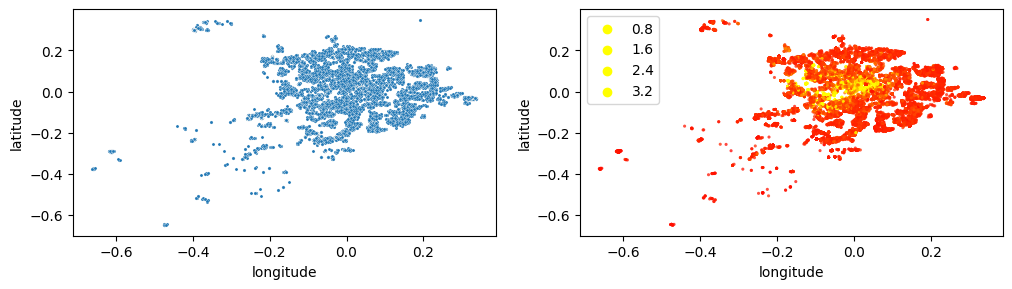

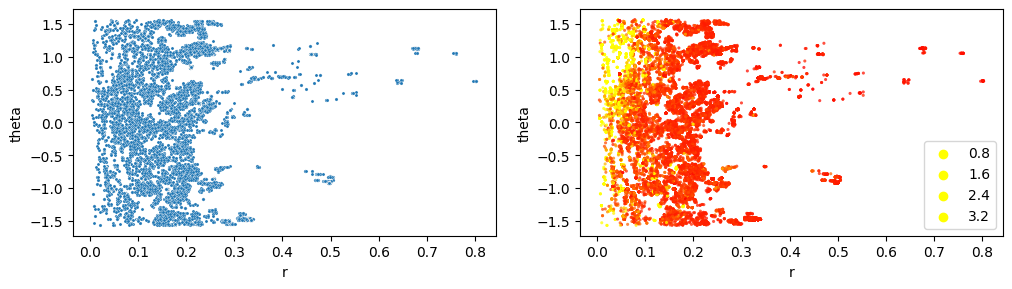

In [105]:
# Cartesian plot
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)
lo, hi = targets1.quantile([0.0, 0.9])
hue_norm = plt.Normalize(lo, hi)
hue = targets1.tolist()

sns.scatterplot(x='longitude', y='latitude', ax=ax1, alpha=1, s=5, data=labels1_normed_r[['latitude', 'longitude']])
sns.scatterplot(x='longitude', y='latitude', ax=ax2, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['latitude', 'longitude']])

# Polar plot
fig, (ax3, ax4) = plt.subplots(figsize=(12, 3), ncols=2, dpi=100)

sns.scatterplot(x='r', y='theta', ax=ax3, alpha=1, s=5, data=labels1_normed_r[['r', 'theta']])
sns.scatterplot(x='r', y='theta', ax=ax4, hue=hue, alpha=0.75, s=5, palette="autumn", linewidth=0, hue_norm=hue_norm, data=labels1_normed_r[['r', 'theta']])

In [106]:
labels1_normed_r.drop('latitude', inplace=True, axis=1)
labels1_normed_r.drop('longitude', inplace=True, axis=1)
test1_normed_r.drop('latitude', inplace=True, axis=1)
test1_normed_r.drop('longitude', inplace=True, axis=1)
labels1_normed_r.tail()

,area_total,area_kitchen,area_living,floor,rooms,ceiling,bathrooms_shared,bathrooms_private,balconies,constructed,r,theta
23280,0.135330,0.136364,0.066374,0.011111,0.2,0.008529,0.000000,0.250000,0.00000,0.958333,0.424582,0.691360
23281,0.056087,0.080808,0.073352,0.077778,0.0,0.009609,0.250000,0.000000,0.00000,0.809524,0.413492,0.696721
23282,0.103675,0.174747,0.084341,0.177778,0.2,0.008088,0.000000,0.250000,0.00000,0.928571,0.145669,-1.469908
23283,0.226684,0.117172,0.104636,0.011111,0.4,0.009609,0.183001,0.164888,0.13842,0.869048,0.248945,0.213095
23284,0.077332,0.109091,0.059890,0.088889,0.0,0.007941,0.250000,0.000000,0.25000,0.892857,0.144974,0.823417


### Train model on new data
Using same model and technique as used in initial test 5

In [107]:
# Model 1
model1 = tf.keras.Sequential()
model1.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model1.add(Dropout(0.2))
model1.add(Dense(10, activation=tf.nn.relu))
model1.add(Dropout(0.2))
model1.add(Dense(5, activation=tf.nn.relu))
model1.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model1.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle

In [108]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
 
history1 = model1.fit(x=labels1_normed_r, y=targets1,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................Epoch 00432: early stopping


In [109]:
# Results
hist1 = pd.DataFrame(history1.history)
hist1['epoch'] = history1.epoch
hist1.tail(1)

,loss,msle,val_loss,val_msle,epoch
431,0.127813,0.127813,0.058022,0.058022,431


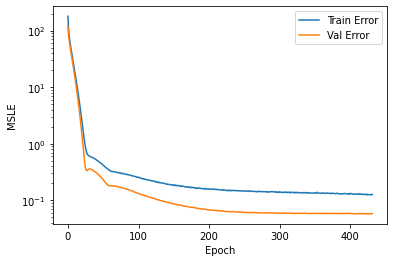

In [121]:
plot_history(hist1)

### Predict and submit

In [111]:
result1 = model1.predict(test1_normed_r)

In [112]:
submission_1 = pd.DataFrame()
submission_1['id'] = test['apartment_id']      
submission_1['price_prediction'] = result1
print("No. predictions:", len(submission_1['id']))

No. predictions: 9937


In [113]:
submission_1.to_csv('advanced_tests/advanced_test_1_1', index=False)

## 2 - Adding categorical data
First, we see that most categorical data is numerical. Easy solution: treat them like numerical data

In [127]:
# Extract, normalize, remove outliers
features = ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", # Numerical
           "condition", "district", "material", "heating", "parking", "building_id"] #Categorical and more
labels2_n, test2_n, targets2 = preProcess_numericalData(features, train, test, outliers_value=7)

In [128]:
# Polar coordinates
labels2_n_r, test2_n_r = polar_coordinates(labels2_n, test2_n)

### Training

In [133]:
# Model 2
model2 = tf.keras.Sequential()
model2.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model2.add(Dropout(0.2))
model2.add(Dense(10, activation=tf.nn.relu))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation=tf.nn.relu))
model2.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model2.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['msle']) #-msle

In [134]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
history2 = model2.fit(x=labels2_n_r, y=targets2,
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [135]:
# Results
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail(1)

,loss,msle,val_loss,val_msle,epoch
999,0.105503,0.105503,0.054221,0.054221,999


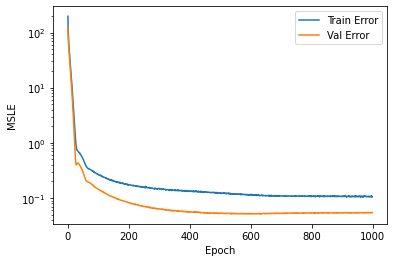

In [136]:
plot_history(hist2)

In [138]:
result = model2.predict(test2_n_r)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']      
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))
submission.to_csv('advanced_tests/advanced_test_2', index=False)

No. predictions: 9937


## 3 - Random validation data

In [65]:
# Extract, normalize, remove outliers
features = ["area_total", "area_kitchen", "area_living", "rooms", "bathrooms_shared", "latitude", "longitude", "district", "parking"]
## NB! Apartment_id added - to add to submission later... Will be noise to training...

# Extract labels, targets and preprocess
labels_n, test_n, targets = preProcess_numericalData(features, train, test, outliers_value=100)
labels_n_r, test_n_r = polar_coordinates(labels_n, test_n)

# Drop useless cols
labels_n_r = labels_n_r.drop(['latitude', 'longitude', 'theta'], 1)
test_n_r = test_n_r.drop(['latitude', 'longitude', 'theta'], 1)

In [56]:
# Extract validation data
msk = np.random.rand(len(labels_n_r)) < 0.9

train_labels = labels_n_r[msk]
val_labels = labels_n_r[~msk]

train_targets = targets[msk]
val_targets = targets[~msk]


In [66]:
#df_val = pd.merge(val_labels, val_targets, left_index=True, right_index=True)
df_train = pd.merge(train_labels, train_targets, left_index=True, right_index=True)
# Compute the correlation matrix
#val_corr = df_val.corr()
train_corr = df_train.corr()
#print("------------Validation------------")
#print(val_corr["price"])
print("-------------Training-------------")
print(train_corr["price"])

-------------Training-------------
area_total          0.804379
area_kitchen        0.230343
area_living         0.458197
rooms               0.429569
bathrooms_shared    0.237831
district           -0.184675
parking            -0.183444
r                  -0.289762
price               1.000000
Name: price, dtype: float64


In [67]:
# Model
model = tf.keras.Sequential()
model.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
model.add(Dropout(0.2))
model.add(Dense(10, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(5, activation=tf.nn.relu))
model.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['mse', 'msle']) #-msle

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", verbose=1, patience=25) # 50
history = model.fit(x=train_labels, y=train_targets,
                    epochs=1000, verbose=0, validation_split = 0.05, #validation_data=(val_labels, val_targets),
                     callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................Epoch 00454: early stopping


In [69]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(1)

,loss,mse,msle,val_loss,val_mse,val_msle,epoch
453,0.120239,7.592928e+14,0.120239,0.06303,4.762710e+13,0.06303,453


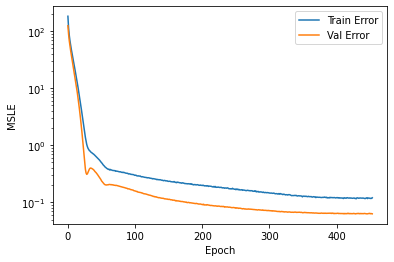

In [70]:
plot_history(hist)

### Predict and save

In [71]:
result = model.predict(test_n_r)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']      
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))

No. predictions: 9937


------------Result------------
area_total          0.973059
area_kitchen        0.396373
area_living         0.778064
rooms               0.696999
bathrooms_shared    0.331331
district           -0.249640
parking            -0.209424
r                  -0.035297
price_prediction    1.000000
Name: price_prediction, dtype: float64


<AxesSubplot:>

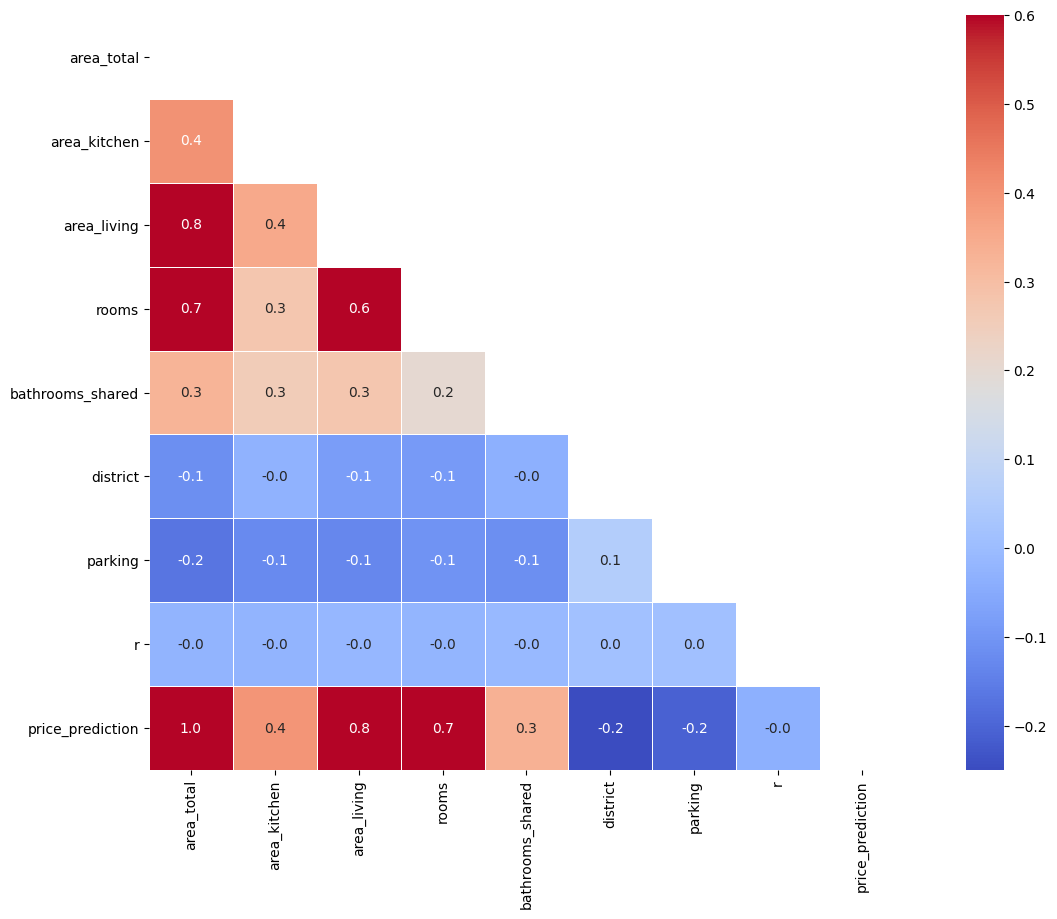

In [72]:
df_result = pd.merge(test_n_r, submission['price_prediction'], left_index=True, right_index=True)
# Compute the correlation matrix
result_corr = df_result.corr()
print("------------Result------------")
print(result_corr["price_prediction"])

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train_corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(16, 10), dpi=100)
sns.heatmap(result_corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

In [73]:
submission.to_csv('advanced_tests/advanced_test_3_4', index=False)

# 4 - Different way of random extractipon

#### Important findings! 
1. The normalization shouldnt be done on training data, validation data and test data seperately! Each will be scaled wrong!
2. The Dropout layers are great for avoiding overfitting, but results in validation data performing better then training data:
    https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models
    

In [38]:
features = ["area_total", "area_living", "floor", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]

# Extract labels, targets and preprocess
outliers_value = 7
no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

In [39]:
# Training and validation data preprocessing
labels = no_outlayers[features]
labels = labels.fillna(labels.mean())
targets = no_outlayers['price']

train_labels, val_labels, train_targets, val_targets = train_test_split(labels, targets, test_size=0.1, shuffle= True, random_state=42)

In [40]:
# Test data preprocessing
test_labels = test[features]
test_labels = test_labels.fillna(test_labels.mean())

### Scaling using sklearn
Two methods are explored. Problem with sklearn.preprocessor is that is returns a numpy array.
We look at a fix for this in the test 5.

In [41]:
# Scale it.
# 0-1 range
#scaler = MinMaxScaler(feature_range=(0, 1))
#train_labels = scaler.fit_transform(train_labels)
#val_labels = scaler.transform(val_labels)
#test_labels = scaler.transform(test_labels)

# Standard scale
std_scale = preprocessing.StandardScaler().fit(train_labels)
train_labels = std_scale.transform(train_labels)
val_labels = std_scale.transform(val_labels)
test_labels = std_scale.transform(test_labels)


In [42]:
# Model
model = tf.keras.Sequential()
model.add(Dense(10, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
#model.add(Dropout(0.2))
model.add(Dense(10, activation=tf.nn.relu))
#model.add(Dropout(0.2))
model.add(Dense(5, activation=tf.nn.relu))
model.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['mse', 'msle']) #-msle

In [43]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=10)
history = model.fit(x=train_labels, y=train_targets.values,
          validation_data=(val_labels,val_targets.values),
          verbose=0, epochs=1000, callbacks=[early_stop, PrintDot()], batch_size=128 
          )

# default batch_size=64


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [44]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(5)

,loss,mse,msle,val_loss,val_mse,val_msle,epoch
995,0.118012,3.720790e+14,0.118012,0.123837,3.975988e+14,0.123837,995
996,0.117979,3.719525e+14,0.117979,0.123791,3.976580e+14,0.123791,996
997,0.117945,3.721240e+14,0.117945,0.123757,3.975920e+14,0.123757,997
998,0.117918,3.720851e+14,0.117918,0.123744,3.974265e+14,0.123744,998
999,0.117884,3.718210e+14,0.117884,0.123696,3.974933e+14,0.123696,999


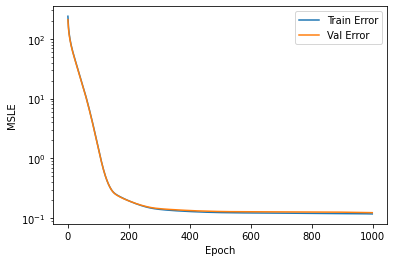

In [45]:
# using batch_size=128 gave a weird "pump" in the loss function.
plot_history(hist)

In [46]:
result = model.predict(test_labels)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']      
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))

No. predictions: 9937


In [47]:
submission.to_csv('advanced_tests/advanced_test_4_8', index=False)

#### Explaining some of the submissions of 4 
= Have not yet tested 4_6, 4_7 and 4_8. 4_8 is most interesting!
- 4_6 is using mse loss function, other wise equals 4_5.
    - In theory, using mse will lead to a lot more overfitting, but using dropout/ validation data will avoid this problem.
- In 4_7 the batch_size argument was removed. This will default to 64.
- 4_8 is a 4_6 clone, but with mean removed. (Using the standard transformer)

### 5 - Add more data, and treat Categorical data "right"!
- Only normalize numerical data.
https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029

In [178]:
# Extract, normalize, remove outliers
Numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed"]
features = ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "ceiling", "bathrooms_shared", "bathrooms_private", "balconies", "latitude", "longitude", "constructed", # Numerical
           "condition", "district", "material", "heating", "parking", "building_id"] #Categorical and more
RANGE=13

In [ ]:
# Mostly the ones correlated to price.
Numerical_features = ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]
features =           ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 
RANGE=11

In [179]:
# Training and validation data preprocessing
labels = train[features]
labels = labels.fillna(labels.mean())
targets = train['price']

train_labels, val_labels, train_targets, val_targets = train_test_split(labels, targets, test_size=0.1, shuffle= True, random_state=42)

In [180]:
# Test data preprocessing
test_labels = test[features]
test_labels = test_labels.fillna(test_labels.mean())

In [181]:
# Only normalize/scale the numerical data. Categorical data is kept as is.
train_labels_n = train_labels[train_labels.columns[0:RANGE]]
val_labels_n = val_labels[val_labels.columns[0:RANGE]]
test_labels_n = test_labels[test_labels.columns[0:RANGE]]

# Normalize Training Data 
std_scale = preprocessing.StandardScaler().fit(train_labels_n)
train_labels_scaled = std_scale.transform(train_labels_n)
val_labels_scaled = std_scale.transform(val_labels_n)
test_labels_scaled = std_scale.transform(test_labels_n)

In [182]:
# Re-enter proceedure
training_norm_col = pd.DataFrame(train_labels_scaled, index=train_labels_n.index, columns=train_labels_n.columns) 
train_labels.update(training_norm_col)

val_norm_col = pd.DataFrame(val_labels_scaled, index=val_labels_n.index, columns=val_labels_n.columns) 
val_labels.update(val_norm_col)

testing_norm_col = pd.DataFrame(test_labels_scaled, index=test_labels_n.index, columns=test_labels_n.columns) 
test_labels.update(testing_norm_col)

In [183]:
# Model
model = tf.keras.Sequential()
model.add(Dense(18, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
#model.add(Dropout(0.2))
model.add(Dense(12, activation=tf.nn.relu))
#model.add(Dropout(0.2))
model.add(Dense(6, activation=tf.nn.relu))
model.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model.compile(optimizer='adam', 
              loss='msle', #'msle'
              metrics=['mse', 'msle']) #-msle

In [184]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=10)
history = model.fit(x=train_labels, y=train_targets.values,
          validation_data=(val_labels,val_targets.values),
          verbose=0, epochs=1000, callbacks=[early_stop, PrintDot()]
          )


....................................................................................................
....................................................................................................
.........Epoch 00209: early stopping


In [185]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(5)

,loss,mse,msle,val_loss,val_mse,val_msle,epoch
204,0.092942,6.861661e+14,0.092942,0.093035,3.809973e+14,0.093035,204
205,0.092952,6.820096e+14,0.092952,0.091605,3.923421e+14,0.091605,205
206,0.093573,6.850847e+14,0.093573,0.098230,3.818806e+14,0.098230,206
207,0.092551,6.825269e+14,0.092551,0.086890,3.864725e+14,0.086890,207
208,0.092768,6.845073e+14,0.092768,0.087345,3.852296e+14,0.087345,208


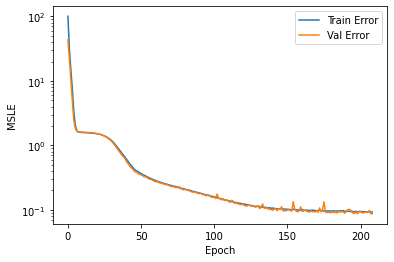

In [186]:
# using batch_size=128 gave a weird "pump" in the loss function.
plot_history(hist)

In [187]:
result = model.predict(test_labels)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))

No. predictions: 9937


In [188]:
# 5_1 uses a smaller selection of features
# 5_2 uses pretty much all numericl and categorical

submission.to_csv('advanced_tests/advanced_test_5_2', index=False)

### 6 - Test the "new" features
- Rel_height, R, spaciousness

In [89]:
# Mostly the ones correlated to price.
features =           ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

Numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", "r", "rel_height"]


In [90]:
# Training and validation data preprocessing
labels = train[features]
labels = labels.fillna(labels.mean())
targets = train['price']

# Test data preprocessing
test_labels = test[features]
test_labels = test_labels.fillna(test_labels.mean())

# ADD R
labels, test_labels = polar_coordinates(labels, test_labels)
# ADD rel_height
labels['rel_height'] = labels["floor"] / labels["stories"]
test_labels['rel_height'] = test_labels["floor"] / test_labels["stories"]

# Split
train_labels, val_labels, train_targets, val_targets = train_test_split(labels, targets, test_size=0.1, shuffle= True, random_state=42)

In [91]:
# Only normalize/scale the numerical data. Categorical data is kept as is.
train_labels_n = train_labels.filter(Numerical_features)
val_labels_n = val_labels.filter(Numerical_features)
test_labels_n = test_labels.filter(Numerical_features)

# Scale it.
scaler = MinMaxScaler(feature_range=(0, 1))
train_labels_scaled = scaler.fit_transform(train_labels_n)
val_labels_scaled = scaler.transform(val_labels_n)
test_labels_scaled = scaler.transform(test_labels_n)

In [92]:
# Re-enter proceedure
training_norm_col = pd.DataFrame(train_labels_scaled, index=train_labels_n.index, columns=train_labels_n.columns) 
train_labels.update(training_norm_col)

val_norm_col = pd.DataFrame(val_labels_scaled, index=val_labels_n.index, columns=val_labels_n.columns) 
val_labels.update(val_norm_col)

testing_norm_col = pd.DataFrame(test_labels_scaled, index=test_labels_n.index, columns=test_labels_n.columns) 
test_labels.update(testing_norm_col)

In [93]:
train_labels.drop(['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'], inplace=True, axis=1)
val_labels.drop(['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'], inplace=True, axis=1)
test_labels.drop(['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'], inplace=True, axis=1)

In [96]:
# Model
model = tf.keras.Sequential()
model.add(Dense(18, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
#model.add(Dropout(0.2))
model.add(Dense(12, activation=tf.nn.relu))
#model.add(Dropout(0.2))
model.add(Dense(6, activation=tf.nn.relu))
model.add(Dense(1)) #Output

# Optimized for reducing msle loss.
#model.compile(optimizer='adam', 
#              loss='msle', #'msle'
#              metrics=['mse', 'msle']) #-msle

# Optimized for reducing msle loss.
model.compile(optimizer='adam', 
              loss=rmsle_custom, #'msle', 'rmse', RMSLETF, rmsle_custom
              metrics=['msle', tf.keras.metrics.Accuracy()]) # metrics=['mse', 'msle'] metrics=[tf.keras.metrics.Accuracy()]

In [97]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=40)
history = model.fit(x=train_labels, y=train_targets.values,
          validation_data=(val_labels,val_targets.values),
          verbose=0, epochs=1000, callbacks=[early_stop, PrintDot()]
          )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [98]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(1)

,loss,msle,accuracy,val_loss,val_msle,val_accuracy,epoch
999,0.227023,0.054347,0.0,0.224719,0.052605,0.0,999


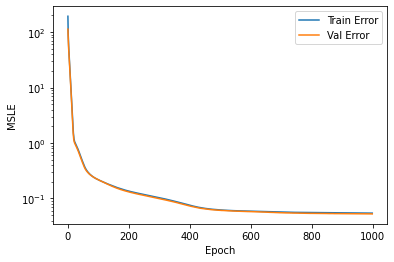

In [99]:
plot_history(hist)

In [100]:
result = model.predict(test_labels)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))

No. predictions: 9937


In [101]:
# 6_1 Introduces R and drops some heavily correlated values: 0.05 MSLE
# 6_2 replaces floor stories, with rel_height instead: 0.05 MSLE => kaggle score of 0.24805
# 6_3: repeat 6_2 with new loss function! RMSLE! => RMSLE score of 0.224719, kaggle score of 
submission.to_csv('advanced_tests/advanced_test_6_3', index=False)

### 7 - One hot encoding categorical features.
- Eventually: One-hot encode other data:
    - Ordinal categorical data can just remain. 
    - Non ordinal categorical data is: parking, district, material, heating, condition.
    
- Also: dont fillnan.mean for categorical non-ordinal data. Rather fill with sensible value.

Problem with little used materials: how to solve.
https://stackoverflow.com/questions/57946006/one-hot-encoding-train-with-values-not-present-on-test

In [104]:
%run utils.py

In [105]:
# Mostly the ones correlated to price.
features =           ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                     "district", "material", "parking"] 
cat_features =       ["district", "parking", "material"] #Non-ordinal
Numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", "r", "theta", "rel_height"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories', 'theta']

In [106]:
train_labels, train_targets, val_labels, val_targets, test_labels = pre_process_numerical(
    features, Numerical_features, train, test, outliers_value=7, val_split=0.1, random_state=42, scaler="std",
    add_R="True", add_rel_height="True", droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

### Now. Lets test out one-hot encoding our categorical data!
Non ordinal categorical data is "district", "parking", "material"

In [107]:
# Model
model = tf.keras.Sequential()
model.add(Dense(18, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
#model.add(Dropout(0.2))
model.add(Dense(12, activation=tf.nn.relu))
#model.add(Dropout(0.2))
model.add(Dense(6, activation=tf.nn.relu))
model.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model.compile(optimizer='adam', 
              loss=RMSLETF, #'msle', RMSLETF, root_mean_squared_error_2, root_mean_squared_error
              ) # metrics=['mse', 'msle'] metrics=[tf.keras.metrics.Accuracy()]

In [108]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=40)
history = model.fit(x=train_labels, y=train_targets.values,
          validation_data=(val_labels,val_targets.values),
          verbose=0, epochs=1000, callbacks=[early_stop, PrintDot()]
          )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................Epoch 00430: early stopping


In [109]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(1)

,loss,val_loss,epoch
429,11558267.0,12266761.0,429


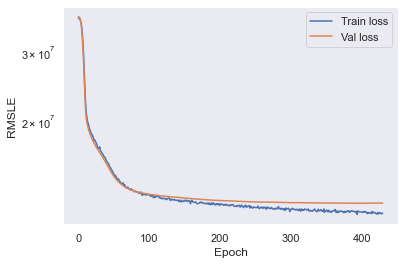

In [110]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.yscale("log")
plt.plot(hist['epoch'], hist['loss'], label='Train loss')
plt.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
plt.legend()
plt.show()

In [111]:
result = model.predict(test_labels)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))

No. predictions: 9937


In [113]:
# 7_1 Uses districts, parking and material. Uses mean to fill nan.
# 7_2 Is the same but uses 'rmse' root_mean_squared_error (home made)
#      - WOW! here R is suddenly on top for some reason.
# 7_3 Is the same but uses RMSLETF (from internet)
# 7_4 Is the same but uses RMSE from internet root_mean_squared_error_2

submission.to_csv('advanced_tests/advanced_test_7_4', index=False)

<AxesSubplot:>

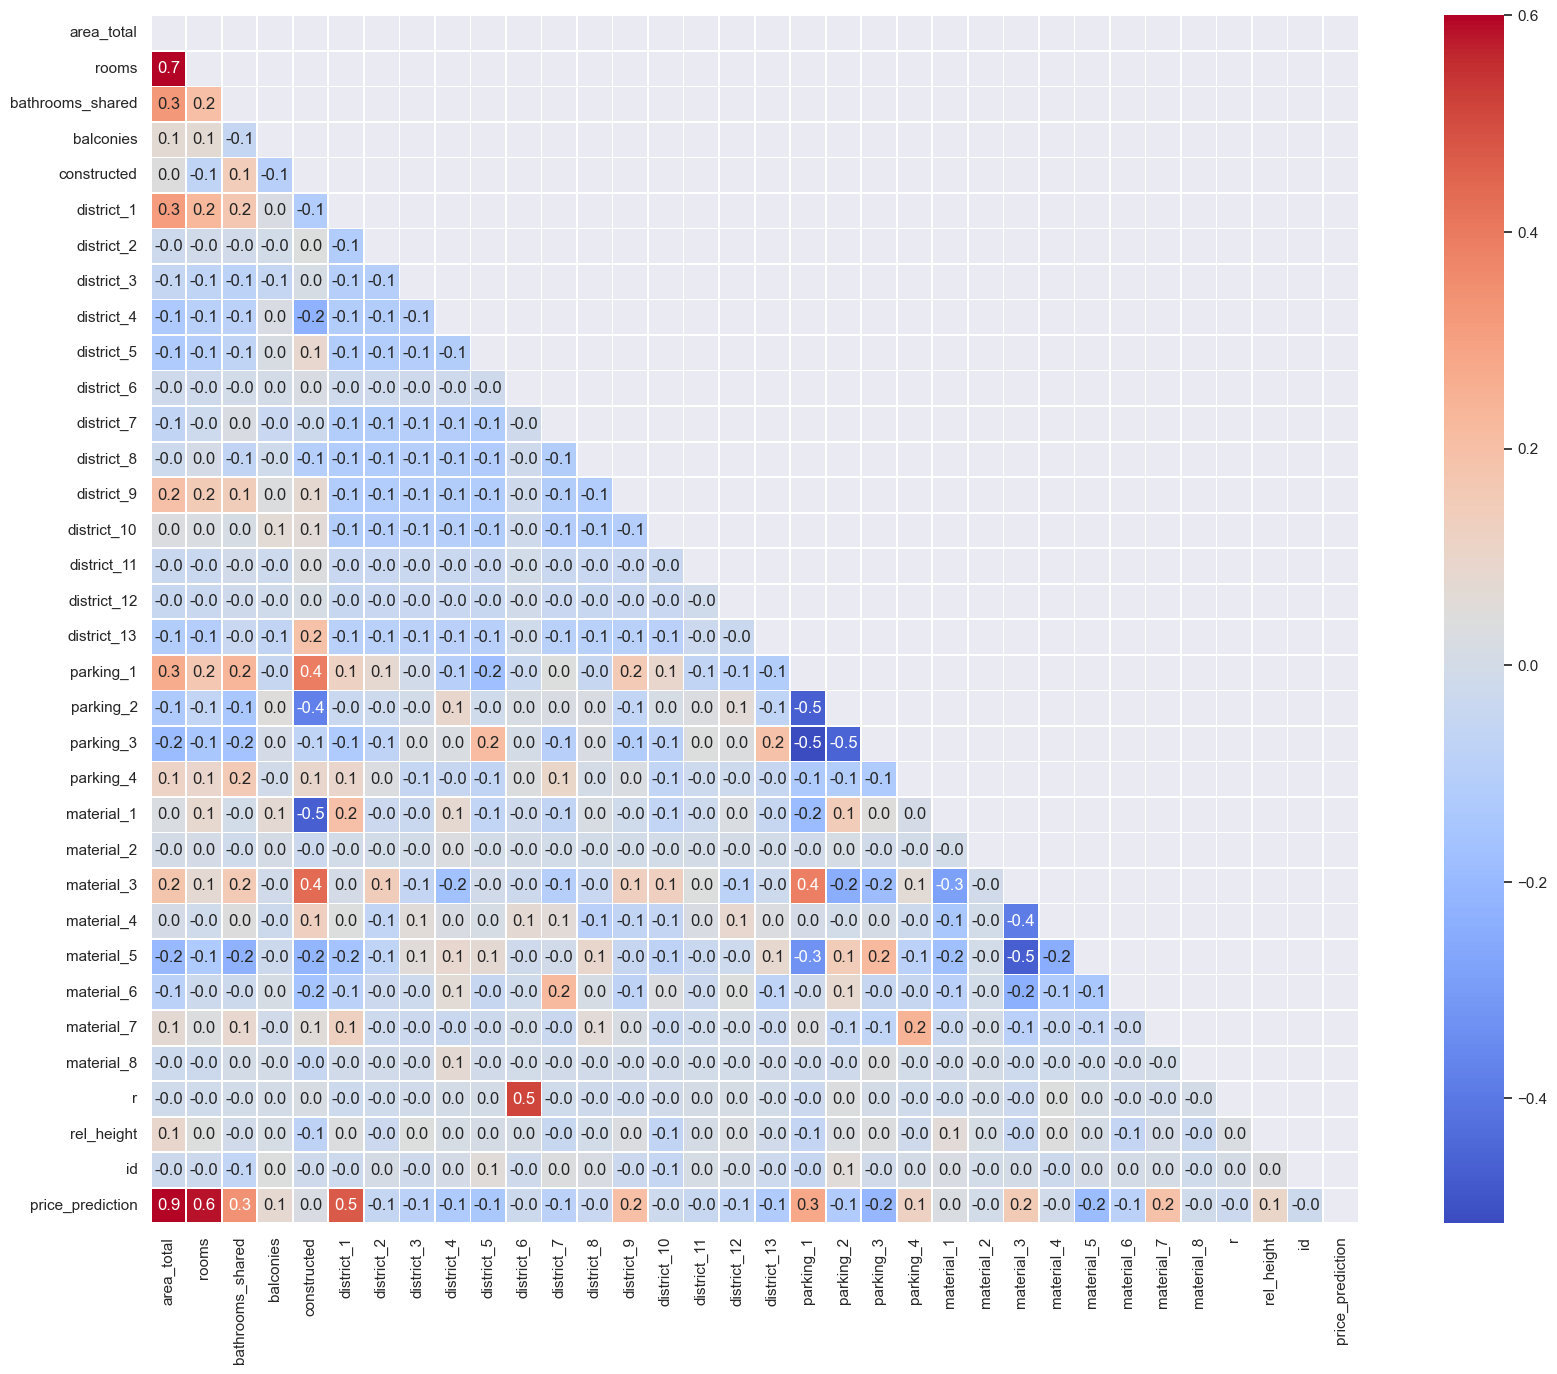

In [112]:
df_all = pd.merge(test_labels, submission, left_index=True, right_index=True)
# Compute the correlation matrix
corr = df_all.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax1 = plt.subplots(figsize=(22, 16), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.set_theme(style="dark")
sns.heatmap(corr, mask=mask, vmax=0.6, square=True, cmap='coolwarm', annot=True, linewidths=.5, fmt= '.1f',ax=ax1)

### 8 - Combining some highlights from this notebook!

6_2_2 got the best score ever! Take its features and preprocessing!
7_4 showed the effect of the new RMSLE function! Might lead to great things!

In [27]:
# %run utils.py - This is what was used for 8_5, this might be the problem??
%run ../common_utils.py

In [28]:
train, test, metaData = load_all_data() # This was not here before either.

In [29]:
# Mostly the ones correlated to price.
features =           ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                    "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

In [30]:
train_labels, train_targets, val_labels, val_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True", droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

# New version
#pre_process_numerical(features, numerical_features, train, test, metadata=[],
#                    outliers_value=7, val_data=True, val_split=0.1, random_state=42, scaler="none",
#                    add_R=False, add_rel_height=False, add_spacious=False, droptable=[],
#                    one_hot_encode=True, cat_features=[], drop_old=True)

Hot encoding
minMax


In [31]:
# Model
model = tf.keras.Sequential()
model.add(Dense(18, activation=tf.nn.relu)) #tf.keras.activations.sigmoid
#model.add(Dropout(0.2))
model.add(Dense(12, activation=tf.nn.relu))
#model.add(Dropout(0.2))
model.add(Dense(6, activation=tf.nn.relu))
model.add(Dense(1)) #Output

# Optimized for reducing msle loss.
model.compile(optimizer='adam', 
              loss=rmsle_custom, #'msle', 'rmse', RMSLETF, rmsle_custom
              metrics=['mse', 'msle', tf.keras.metrics.Accuracy()]) # metrics=['mse', 'msle'] metrics=[tf.keras.metrics.Accuracy()]

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=40)
history = model.fit(x=train_labels, y=train_targets.values,
          validation_data=(val_labels,val_targets.values),
          verbose=0, epochs=1000, callbacks=[early_stop, PrintDot()]
          )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [33]:
# Results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#hist.loc[hist["val_loss"]==hist["val_loss"].min()]
hist.tail(5)

,loss,mse,msle,accuracy,val_loss,val_mse,val_msle,val_accuracy,epoch
995,0.216535,2.038378e+14,0.049445,0.0,0.220719,2.294409e+14,0.051973,0.0,995
996,0.216828,2.039155e+14,0.049449,0.0,0.220657,2.297429e+14,0.051938,0.0,996
997,0.216533,2.037802e+14,0.049440,0.0,0.220507,2.302242e+14,0.051845,0.0,997
998,0.216200,2.038769e+14,0.049404,0.0,0.220666,2.301619e+14,0.051914,0.0,998
999,0.216729,2.038984e+14,0.049428,0.0,0.220725,2.299288e+14,0.051961,0.0,999


In [53]:
### SOLVING MYSTERY CELL
# So, its says val_loss ~ 0.2, but the final score is 0.5 ish.
prediction=model.predict(val_labels)
print(rmsle_custom(val_targets.values, prediction))
print(root_mean_squared_log_error(prediction, val_targets.values))

tf.Tensor(1.1688507, shape=(), dtype=float32)
1.1688502892195876


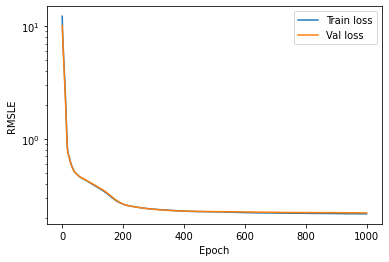

In [42]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.yscale("log")
plt.plot(hist['epoch'], hist['loss'], label='Train loss')
plt.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
plt.legend()
plt.show()

In [43]:
result = model.predict(test_labels)
submission = pd.DataFrame()
submission['id'] = test['apartment_id']
submission['price_prediction'] = result
print("No. predictions:", len(submission['id']))

No. predictions: 9937


In [44]:
model.save('models/replica_model_1') # GOT a 0.24787 kaggle score

INFO:tensorflow:Assets written to: models/replica_model_1\assets


In [45]:
submission.to_csv('advanced_tests/advanced_test_8_5_2', index=False)

#### Different results
8_1 working on RMSE (no L!) => root_mean_squared_error_2 which was used on 7_4 to great success.
- It is really good and solid, but requires some restarts: seems to bit unstable in the opening.
- Relies on Keras backend and seems to work with metrics.

8_2 working more on RMSLE => root_mean_squared_log_error_2
- Same as 8_1 requires some restarts, and relies on Keras backend.
- Turned off early_stopping as it resulted in some weird ealrly stops.
- For some reasons fails to track metrics, like val_loss in history - but seemingly uses it for early-stop
    => BUG! After some time (around 200 episodes), the val started coming out as nans. Worked "well" up until that point.

8_3 uses RMSLETF from internet, like test 7_3 did with some ok results.
- Uses tf.math to do tensor operations.
- Seems stable, unlike some of the others.
- Gets some weid un-scaled results that cannot be compared to kaggle...!

8_4 Uses the rmsle_custom function from kaggle. => val_loss of 0.215 (0.25267)
- This seems to be the best! If this score is close to the kaggle score we are sold!
- Lets test it with metrics! Also works with MSLE

8_5 trying to replicate the GOD! To save the model away for stacking!
- 8_5_1: 0.211080 => 0.50528 ??????

### SOLVING THE MYSTERY

In [46]:
# Mostly the ones correlated to price.
features =           ["building_id", 
                      "area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
                        "district", "material", "parking"] 

numerical_features = ["area_total", "area_kitchen", "area_living",
                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]

cat_features = ["district", "material", "parking"]

droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

In [69]:
%run ../common_utils.py

In [70]:
train, test, metaData = load_all_data()

In [71]:
train_labels, train_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_data=False, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True", droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

Hot encoding
minMax


In [72]:
model_params = ([18, 12, 6], tf.nn.relu,
                     [False, False, False], 0.2, 'adam',
                      rmsle_custom, ['accuracy'], False)

In [73]:
scores, avg, best_model, best_index = ANN_groupKFold(5, model_params, train_labels, train_targets)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................Epoch 00660: early stopping
        loss  accuracy  val_loss  val_accuracy  epoch
659  0.20846       0.0  0.209486           0.0    659
Score: 1.1305469479875174 	( tf.Tensor(1.1305474, shape=(), dtype=float32) )
Best score: 100
New best model!

.......................................................................................

In [74]:
print(scores)
print("=>",avg)

[1.1305469479875174, 1.1836050872995931, 1.1246595145981, 16.66540325961269, 1.1849220081844039]
=> 4.257827363536462


In [76]:
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="advanced_tests/solving_mystery_2", exponential=False)

### 9 - Deeper nets

In [2]:
%run ../common_utils.py
pd.options.mode.chained_assignment = None

In [5]:
tls = []
tts = []
vls = []
vts = []
tstl = []
train, test, metaData = load_all_data()

# Features 1 "All features"
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating"]

droptable = ['longitude', 'latitude']

# 8_4_2 REPLICA
train_labels, train_targets, val_labels, val_targets, test_labels = pre_process_numerical(
    features, numerical_features, train, test, outliers_value=7, val_split=0.1, random_state=42, scaler="minMax",
    add_R="True", add_rel_height="True", droptable=droptable,
    one_hot_encode=True, cat_features=cat_features, drop_old=True)

tls.append(train_labels)
tts.append(train_targets)
vls.append(val_labels)
vts.append(val_targets)
tstl.append(test_labels)

tls.append(train_labels)
tts.append(train_targets)
vls.append(val_labels)
vts.append(val_targets)
tstl.append(test_labels)

tls.append(train_labels)
tts.append(train_targets)
vls.append(val_labels)
vts.append(val_targets)
tstl.append(test_labels)

tls.append(train_labels)
tts.append(train_targets)
vls.append(val_labels)
vts.append(val_targets)
tstl.append(test_labels)

tls.append(train_labels)
tts.append(train_targets)
vls.append(val_labels)
vts.append(val_targets)
tstl.append(test_labels)


In [6]:
# Creater 5 different models to stack
# https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object

model1 = create_ANN_model(dense_layers=[18,12,6], dropout=[False, False, False], dropout_rate=0, output_activation=False) 
model2 = create_ANN_model(dense_layers=[18,12,6], dropout=[False, False, False], dropout_rate=0, output_activation=True) 
model3 = create_ANN_model(dense_layers=[64,64,64], dropout=[False, False, False], dropout_rate=0, output_activation=False)
model4 = create_ANN_model(dense_layers=[64,64,64], dropout=[False, False, False], dropout_rate=0, output_activation=True)
model5 = create_ANN_model(dense_layers=[64,64,64], dropout=[True, False, False], dropout_rate=0.2, output_activation=True)
models = [model1, model2, model3, model4, model5]

losses = []
epochs = [1000, 1000, 1000, 1000, 1000]
for i, model in enumerate(models):
    train_labels = tls[i]
    train_targets = tts[i]
    val_labels = vls[i]
    val_targets = vts[i]
    test_labels = tstl[i]
    e = epochs[i]
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=40)
    history = model.fit(x=train_labels, y=train_targets.values,
              validation_data=(val_labels,val_targets.values),
              verbose=0, epochs=e, callbacks=[early_stop, PrintDot()]
              )
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    losses.append(hist['val_loss'].tail(1))
    model.save('models/good_models_5_'+str(i))
    predict_and_store(model, test_labels, test, path='advanced_tests/deeper_5_0_'+str(i))


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [7]:
# deeper_2_0 is a deeper network, with all features but no regulaization: 0.173925
# deeper_2_1 is the exact same, but with dropout: 0.184942
# deeper_2_2 is using the previously "best" features: 0.199417 => 0.50924

# Uses all features
# deeper_3_0 Uses only regularization on first layer, and uses RELU on output!: 0.162473 => 0.49606
# deeper_3_1 Uses only regularization on first layer, and does not!: 0.166994

# Saved over the 3_ tests:(
# deeper_4_0 is a copy of deeper_3_0 for reproductivity: 
# deeper_4_1 is a lot deeper and has more dropout layers as well: 
# deeper_4_2 is Uses no one hot encoding - direct use of categorical data: 
# deeper_4_3 is a replica of 4_2 for reproducability: 

# Dropout seems to make the score worse somehow?
#TODO: test different scalers! Test the 8_4_2 with a deeper net. Is deeper worse?

# All using the "best fetures" from 8_4_2, and same settings. 
# deeper_5_0_0 is replication of 8_4_2:     0.214886
# deeper_5_0_1 .. also adds relu on output: 0.20873
# deeper_5_0_2 Uses the max depth:          0.165142
# deeper_5_0_3 .. also adds relu on output: 0.17188
# deeper_5_0_4 .. also adds regulaization:  0.174492


In [8]:
print(losses)

[999    0.214886
Name: val_loss, dtype: float64, 999    0.20873
Name: val_loss, dtype: float64, 984    0.165142
Name: val_loss, dtype: float64, 738    0.17188
Name: val_loss, dtype: float64, 999    0.174492
Name: val_loss, dtype: float64]


In [9]:
result = model1.predict(tstl[0])
print(result.min(), result.mean(), result.max())
result = model2.predict(tstl[1])
print(result.min(), result.mean(), result.max())

-180542030.0 21397798.0 551118700.0
-54300940.0 21767812.0 598660500.0


In [37]:
train_prices = train.price.values
print(train_prices.min(), train_prices.mean(), train_prices.max())

900000.0 23556173.4710758 2600000000.0


### 10 - Stratified grouped k-fold validation
sklearn.model_selection.StratifiedGroupKFold! Apartments from different buildings should not be in different datasets (val, train)
   - Also - stratified: makes y data is equally represented in different datasets (train, val): can pass log(y) or something into the StratifiedGroupKFold, and then extract price from X or something.

From sklearn 1.0.1: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html

Home made kaggle stuff: https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation/notebook

##### K-fold validation
#### Sources
- https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
- https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

A method to validate model more accurately than just using one set of validation data.
Also: stacking the k-fold models could lead to better accuracy, as the result is a model that has seen and trained on all the data.

In [84]:
%run ../common_utils.py
pd.options.mode.chained_assignment = None

In [85]:
train, test, metaData = load_all_data()

In [86]:
# Features "All features"
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating"]

droptable = ['longitude', 'latitude']

In [94]:
X, y, test_labels = pre_process_numerical(features, numerical_features, train, test,
                                          outliers_value=7, val_data=False, random_state=42, scaler="std",
                                          add_R="True", add_rel_height="True", droptable=droptable,
                                          one_hot_encode=True, cat_features=cat_features, drop_old=True)


print(X.size, X.shape)
print(y.size, y.shape)
# X array-like of shape (n_samples, n_features)
# y array-like of shape (n_samples,)
# groups array-like of shape (n_samples,)

X_np = X.to_numpy()
y_np = y.to_numpy()

789616 (23224, 34)
23224 (23224,)


In [95]:
groups = X["building_id"]
print(groups.size, groups.shape)
groups_np = groups.to_numpy()

#X.drop(["building_id"], inplace=True) 

23224 (23224,)


In [97]:
cv = StratifiedGroupKFold(n_splits=10)

https://stackoverflow.com/questions/51852551/key-error-not-in-index-while-cross-validation

In [98]:
returned = cv.split(X, y, groups)

In [99]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [100]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/saved_models/'
fold_var = 1

for train_index, val_index in cv.split(X, y, groups):
    train_labels = X.iloc[train_index]
    train_targets = y.iloc[train_index]
    val_labels = X.iloc[val_index]
    val_targets = y.iloc[val_index]

    # CREATE NEW MODEL
    model = create_ANN_model()

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                            monitor='val_loss', verbose=0, 
                            save_best_only=True, mode='min')
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=40)
    callbacks_list = [checkpoint]

    # FIT THE MODEL
    history = model.fit(x=train_labels, y=train_targets,
              validation_data=(val_labels,val_targets),
              verbose=0, epochs=10000, callbacks=[checkpoint, early_stop, PrintDot()]
              )
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights("/saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(x=val_labels, y=val_targets)
    results = dict(zip(model.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    
    
    model.save('models/KFOLD_models_'+str(fold_var))
    predict_and_store(model, test_labels, test, path='advanced_tests/KFOLD_'+str(fold_var))
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    

c:\users\henri\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:880: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................Epoch 00428: early stopping
73/73 [==============================] - 0s 707us/step - loss: 0.2419 - accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: models/KFOLD_models_1\assets

....................................................................................................
....................................................................................................
....................................................................................................
..............Epoch 00314: early stopping
73/73 [=============================

In [101]:
VALIDATION_LOSS

[0.24188350141048431,
 0.24085019528865814,
 0.2558126449584961,
 0.22893477976322174,
 0.203695610165596,
 0.22078844904899597,
 0.20134416222572327,
 0.21290895342826843,
 0.21781134605407715,
 0.21119308471679688]

In [1]:
# What happened? Well, the score was way worse! Got around 0.5 no matter what... I did.
# Maybe the validation doesnt work, but it is the same for all deep learning! All DL models get 0.2 on notebook => 0.5 on kaggle...?

### 11 The newest tech!
TODO - use rmse loss function, and log the targets instead of using rmsle.

TODO - learning rate

In [86]:
# ALL, and building ID!
features =           ["building_id", # For grouping
                      "area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms",
                      "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", "seller", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] # Strings

all_numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

float_numerical_features = ["area_total", "area_kitchen", "area_living", "ceiling", "latitude", "longitude", "constructed"]
int_numerical_features = ["floor", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies", "loggias", "phones"] # Ordinal categories

cat_features = ["layout", "condition", "district", "material", "parking", "heating", "seller"] # All are non-ordinal

droptable = []

In [87]:
%run ../common_utils.py
# Load data
train, test, metaData = load_all_data()
# Clean data
train_labels, train_targets, test_labels = clean_data(train, test, features, float_numerical_features, int_numerical_features, cat_features, log_targets=False, log_area=True, fillNan=True)

In [88]:
# Add new features
train_labels, test_labels, added_features = feature_engineering(train_labels, test_labels, float_numerical_features, int_numerical_features, cat_features)

In [89]:
# Normalize
train_labels, test_labels = normalize(train_labels, test_labels, float_numerical_features, scaler="minMax")

minMax


In [90]:
## Drop the worst stuff
#droptable = ["bathrooms_private", "bathrooms_shared","longitude", "latitude", "rel_kitchen", "area_kitchen", "area_living",  # Dropped cuz they correlate too much with other features
#            "theta", "rel_height", "loggias", "elevator_passenger", "layout", "phones", "rel_height", "windows_court", "balconies", "garbage_chute", "new",  # Dropped cuz they suck
#             ]
#train_labels.drop(droptable, inplace=True, axis=1)
#test_labels.drop(droptable, inplace=True, axis=1)

In [91]:
# One-hot encoding
train_labels, test_labels = one_hot_encoder(train_labels, test_labels, ["condition", "district", "material", "parking", "heating", "seller"], drop_old=True)

In [92]:
## Drop the worst stuff. This list was made with log(targets), removing all with correlation less than 0.1.
#droptable = droptable = ["material_1", "district_9", "heating_2", "district_2", "material_7", "material_2",  
# "condition_3", "district_7", "heating_3", "seller_4", "heating_1", "district_3",
# "district_10", "district_6", "seller_1"]
#train_labels.drop(droptable, inplace=True, axis=1)
#test_labels.drop(droptable, inplace=True, axis=1)

In [93]:
#f, ax = plt.subplots(figsize=(2, 16), dpi=100)
#heatmap = sns.heatmap(pd.merge(train_labels, train_targets, left_index=True, right_index=True).corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax)

In [94]:
## TODO! Use a deeper net, with regularization maybe :D
model_params = ([18, 18, 18], tf.nn.leaky_relu,
                     [False, False, False], 0.2, tf.keras.optimizers.Adam, #'adam'
                      rmsle_custom, ['mse', 'msle', tf.keras.metrics.Accuracy()], True,
               0.01) # 0.001 was the good old

In [95]:
ann_scores, models, best_model, hists = ANN_groupKFold(5, model_params, train_labels, train_targets)


.......................................................................Epoch 00071: early stopping
New best model!

....................................................................................................
.....................Epoch 00121: early stopping
New best model!

...............................................................................................Epoch 00095: early stopping
New best model!

..........................................................................................Epoch 00090: early stopping

....................................................................................................
...........................................................................................Epoch 00191: early stopping


In [96]:
print(ann_scores)
print("==>\t", np.average(ann_scores))

[0.221836119890213, 0.20564785599708557, 0.19526667892932892, 0.21623128652572632, 0.2244594693183899]
==>	 0.21268828213214874


In [69]:
predict_and_store(best_model, test_labels.drop(["building_id"], axis=1), test, path="advanced_tests/new_tech_1", exponential=False)
#for i in range(5):
#    predict_and_store(models[i], test_labels.drop(["building_id"], axis=1), test, path="advanced_tests/new_tech_"+str(5+i), exponential=False)


In [ ]:
# new_tech_0: drops a lot of features, uses one-hot encoding. ~ 0.22
# new_tech_1: doesnt drop features. Also one-hot encodes.     ~ 0.212
# new_tech_: doesnt drop, doesnt one-hot encode.              ~ 
# new_tech_: does ... and more deep layers.                   ~ 

In [70]:
# Results
history = hists[4]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(2)

,loss,mse,msle,accuracy,val_loss,val_mse,val_msle,val_accuracy,epoch
998,0.221779,8.376449e+14,0.052063,0.0,0.238156,3.060110e+15,0.073129,0.0,998
999,0.221797,8.357624e+14,0.052044,0.0,0.238091,3.068695e+15,0.073182,0.0,999


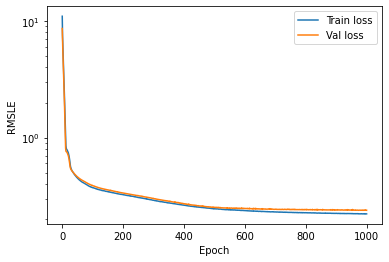

In [71]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('RMSLE')
plt.yscale("log")
plt.plot(hist['epoch'], hist['loss'], label='Train loss')
plt.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
plt.legend()
plt.show()